In [ ]:
# Start writing code here...

# TICKIT

Desarrolle una solución en la nube del proveedor de su preferencia usando el dataset TICKIT, esta base de datos de ejemplo es utilizado para rastrear la actividad de ventas del sitio web ficticio TICKIT, donde los usuario compran y venden boletos en línea para eventos deportivos, espectáculos y conciertos. En particular, los analistas pueden identificar el movimiento de boletos a lo largo del tiempo, las tasas de éxito de los vendedores y los eventos, lugares y temporadas más vendidos. Los analistas pueden utilizar esta información para proporcionar incentivos a los compradores y vendedores que frecuentan el sitio, para atraer a nuevos usuarios y para generar publicidad y promociones.

## Problema

Se desea realizar un modelo de Forecast con cualquier técnica de su preferencia para pronosticar las ventas para los siguientes 7 días desde el final del histórico de datos, tenga en cuenta que la fecha de la venta se encuentra en la variable “saletime” y que esta está mostrada a una granularidad de factura individual

### Importando el Data Set

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
colnames = ["salesid","listid","sellerid","buyerid","eventid","dateid","qtysold","pricepaid","commission","saletime"]

In [ ]:
url = ('tickitdb/sales_tab.txt')
train_data = pd.read_csv(url, header=None, sep='\t')

In [ ]:
train_data.columns = colnames

In [ ]:
pd.set_option('display.max_columns', None) 

In [ ]:
train_data.head()

,salesid,listid,sellerid,buyerid,eventid,dateid,qtysold,pricepaid,commission,saletime
0,1,1,36861,21191,7872,1875,4,728,109.20,2/18/2008 02:36:48
1,2,4,8117,11498,4337,1983,2,76,11.40,6/6/2008 05:00:16
2,3,5,1616,17433,8647,1983,2,350,52.50,6/6/2008 08:26:17
3,4,5,1616,19715,8647,1986,1,175,26.25,6/9/2008 08:38:52
4,5,6,47402,14115,8240,2069,2,154,23.10,8/31/2008 09:17:02


### Converción del campo saletime a datetime

In [ ]:
train_data.saletime = pd.to_datetime(train_data.saletime)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172456 entries, 0 to 172455
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   salesid     172456 non-null  int64         
 1   listid      172456 non-null  int64         
 2   sellerid    172456 non-null  int64         
 3   buyerid     172456 non-null  int64         
 4   eventid     172456 non-null  int64         
 5   dateid      172456 non-null  int64         
 6   qtysold     172456 non-null  int64         
 7   pricepaid   172456 non-null  int64         
 8   commission  172456 non-null  float64       
 9   saletime    172456 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 13.2 MB


In [ ]:
#SAcar la fecha
train_data.saletime.dt.date

0         2008-02-18
1         2008-06-06
2         2008-06-06
3         2008-06-09
4         2008-08-31
             ...    
172451    2008-10-22
172452    2008-08-30
172453    2008-10-10
172454    2008-12-03
172455    2008-07-05
Name: saletime, Length: 172456, dtype: object

In [ ]:
df_group = train_data[['saletime', 'pricepaid']].groupby([train_data.saletime.dt.date]).sum()
df_group


,pricepaid
saletime,
2008-01-01,9544
2008-01-02,19968
2008-01-03,24851
2008-01-04,57262
2008-01-05,68062
...,...
2008-12-27,42491
2008-12-28,59581
2008-12-29,42623


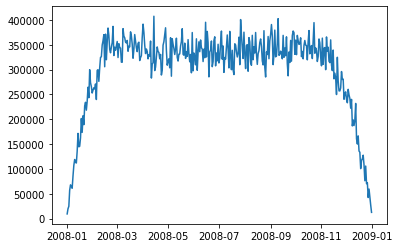

In [ ]:
plt.plot(df_group)

Nota: El negocio va en una caida casí exponencial quizás indique un posible quiebra por ende el modelo de predicción de valores muy bajos decrecientes.

### Modelo AR

In [ ]:
!pip install statsmodels==0.13.2

     |████████████████████████████████| 9.8 MB 18.3 MB/s 
     |████████████████████████████████| 233 kB 38.3 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from statsmodels.tsa.ar_model import AutoReg

### Entrenar el modelo

In [ ]:
train_data = df_group[:len(df_group)-100]
test_data = df_group[len(df_group)-100:]

In [ ]:
ar_model = AutoReg(train_data, lags=7).fit()

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Predicciones

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


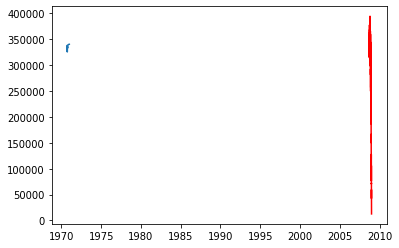

In [ ]:
pred = ar_model.predict(start=len(train_data), end=(len(df_group)-1), dynamic=False)
#
# Plot the prediction vs test data
#
plt.plot(pred)
plt.plot(test_data, color='red')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9ee48c94-9986-4ddb-8df6-8c7e6f24a682' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>